In [8]:
%matplotlib inline
import importlib
import argparse
import os
import sys
import time
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import random
import numpy as np
import yaml
from box import Box
from pprint import pprint
import wandb
from tqdm import tqdm
from datetime import timedelta
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


CONFIG_FILENAME = '/home/liranc6/ecg_forecasting/liran_project/mrdiff/src/config_ecg.yml'

assert CONFIG_FILENAME.endswith('.yml')

with open(CONFIG_FILENAME, 'r') as file:
    config = yaml.safe_load(file)

# Add the parent directory to the sys.path
ProjectPath = config['project_path']
sys.path.append(ProjectPath)

from liran_project.mrdiff.src.parser import parse_args
from liran_project.utils.dataset_loader import SingleLeadECGDatasetCrops_mrDiff as DataSet
from liran_project.utils.util import ecg_signal_difference
# from liran_project.mrdiff.exp_main import Exp_Main
from liran_project.utils.common import *

# Add the directory containing the exp module to the sys.path
exp_module_path = os.path.join(ProjectPath, 'mrDiff')
sys.path.append(exp_module_path)

# from mrDiff.exp.exp_main import Exp_Main
from mrDiff.data_process.etth_dataloader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom, Dataset_Wind, Dataset_Caiso, Dataset_Production, Dataset_Caiso_M, Dataset_Production_M
from mrDiff.data_process.financial_dataloader import DatasetH
from mrDiff.data_process.forecast_dataloader import ForecastDataset
from mrDiff.exp.exp_basic import Exp_Basic
from mrDiff.models_diffusion import DDPM
from mrDiff.utils.tools import EarlyStopping, adjust_learning_rate, visual
from mrDiff.utils.metrics import metric

from liran_project.mrdiff.src.parser import Args

In [235]:
import numpy as np
import pywt
from sklearn.decomposition import PCA
import emd  # Using PyHHT for Empirical Mode Decomposition
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert

In [2]:
from mrDiff.models_diffusion.DDPM_CNNNet import *
from mrDiff.models_diffusion.DDPM_diffusion_worker import *
from mrDiff.models_diffusion.DDPM import *

# smoothed_factors = [5, 10, 25]
# decompsitions = nn.ModuleList([series_decomp(i) for i in smoothed_factors])
# num_bridges = len(smoothed_factors)

# batch_x_trend_0 = torch.tensor([[1.2052475214004517], [-1.2326127290725708], [0.04800083115696907], [0.19049109518527985], [-0.7563862204551697], [-0.5678967237472534], [0.7916461825370789], [0.07740737497806549], [-0.08014091849327087], [1.0424736738204956], [0.1513906568288803], [1.3039816617965698], [2.051314115524292], [0.36207422614097595], [0.3534039855003357], [0.7216405272483826], [-0.1926405429840088], [-2.0528838634490967], [2.0230884552001953], [0.4104272127151489], [-0.520502507686615], [1.3188446760177612], [-0.9794839024543762], [0.9755717515945435], [-1.461293339729309], [-0.05635882541537285], [-0.10612424463033676], [-0.19961267709732056], [-0.1930353045463562], [0.9049265384674072], [1.3832439184188843], [-0.3818874657154083], [0.4605606198310852], [-1.044301986694336], [0.12567691504955292], [0.6849595904350281], [0.6683170199394226], [-0.29516831040382385], [2.3603708744049072], [-2.9438042640686035], [-0.19197304546833038], [-0.41678449511528015], [0.49438074231147766], [-2.766122817993164], [-0.199421688914299], [-0.1136804074048996], [0.7538848519325256], [-2.3160653114318848], [1.1208761930465698], [-1.764612078666687]])
# batch_x_trend_0.unsqueeze_(0)
# batch_x_trends = []
# for i in range(num_bridges-1):
#             _, batch_x_trend = decompsitions[i](batch_x_trend_0)
#             print(f"{i} = {batch_x_trend.tolist()}")
#             # print("batch_x_trend", np.shape(batch_x_trend))
            
#             plt.plot(batch_x_trend[0,0,:].cpu().numpy())

#             batch_x_trends.append(batch_x_trend.permute(0,2,1))
#             batch_x_trend_0 = batch_x_trend

In [3]:
import torch

class TrendExtractor:
    def __init__(self, num_bridges, smoothing_weights, decompositions):
        self.num_bridges = num_bridges
        self.smoothing_weights = smoothing_weights
        self.decompsitions = decompositions

    def obtain_multi_trends(self, batch_x):
        # batch_x: (B, N, L)
        print(f"Initial batch_x shape: {batch_x.shape}")
        
        # Permute batch_x to (B, L, N)
        batch_x = batch_x.permute(0, 2, 1)
        print(f"After permute batch_x shape: {batch_x.shape}")
        
        batch_x_trends = []
        batch_x_trend_0 = batch_x

        # Sort the smoothing factors based on the learnable weights
        sorted_indices = torch.argsort(self.smoothing_weights, descending=True)
        sorted_decompsitions = [self.decompsitions[i] for i in sorted_indices]
        
        print(f"Smoothing weights: {self.smoothing_weights}")
        print(f"Sorted smoothing indices: {sorted_indices}")
        print(f"Number of decompositions: {len(sorted_decompsitions)}")

        for i in range(self.num_bridges - 1):
            print(f"\nIteration {i+1}:")
            # Apply the i-th decomposition function (trend extraction)
            _, batch_x_trend = sorted_decompsitions[i](batch_x_trend_0)
            
            print(f"batch_x_trend_0 shape: {batch_x_trend_0.shape}")
            print(f"Extracted batch_x_trend shape: {batch_x_trend.shape}")
            
            # Store trend after permuting it back to (B, N, L)
            batch_x_trends.append(batch_x_trend.permute(0, 2, 1))
            batch_x_trend_0 = batch_x_trend  # Update for the next iteration
            
            print(f"batch_x_trend shape after permute: {batch_x_trends[-1].shape}")

        return batch_x_trends

# Mock decomposition functions
def mock_decomposition(x):
    # Mock function returns two parts (irrelevant for now, we only care about the second part)
    return x, x * 0.5  # Just returns 50% scaled version as the "trend"

# Example usage
B, N, L = 2, 3, 5  # Batch size, num features, sequence length
batch_x = torch.randn(B, N, L)  # Random input batch

# Initialize a mock TrendExtractor
num_bridges = 3
smoothing_weights = torch.tensor([0.7, 0.5, 0.9])  # Some arbitrary weights
decompositions = [mock_decomposition, mock_decomposition, mock_decomposition]  # Three mock functions

extractor = TrendExtractor(num_bridges, smoothing_weights, decompositions)

# Call the function with the print statements
batch_x_trends = extractor.obtain_multi_trends(batch_x)

print("\nFinal trends:")
for i, trend in enumerate(batch_x_trends):
    print(f"Trend {i+1} shape: {trend.shape}")
    print(trend)

Initial batch_x shape: torch.Size([2, 3, 5])
After permute batch_x shape: torch.Size([2, 5, 3])
Smoothing weights: tensor([0.7000, 0.5000, 0.9000])
Sorted smoothing indices: tensor([2, 0, 1])
Number of decompositions: 3

Iteration 1:
batch_x_trend_0 shape: torch.Size([2, 5, 3])
Extracted batch_x_trend shape: torch.Size([2, 5, 3])
batch_x_trend shape after permute: torch.Size([2, 3, 5])

Iteration 2:
batch_x_trend_0 shape: torch.Size([2, 5, 3])
Extracted batch_x_trend shape: torch.Size([2, 5, 3])
batch_x_trend shape after permute: torch.Size([2, 3, 5])

Final trends:
Trend 1 shape: torch.Size([2, 3, 5])
tensor([[[ 0.0229,  0.8297, -0.7209,  0.0170, -0.3949],
         [ 0.1840, -0.5097,  0.0789,  0.8377,  1.0249],
         [-0.6960, -0.7417, -0.6386,  0.3676, -1.0451]],

        [[ 0.1831,  0.2362,  0.1590, -0.8220,  0.1013],
         [ 0.7960, -0.2461, -0.1961, -0.0914, -0.0977],
         [-0.6533,  0.1222, -0.0217,  0.5336,  0.0345]]])
Trend 2 shape: torch.Size([2, 3, 5])
tensor([[[ 0.

In [80]:
signal = \
        [-0.2682677751603517, -0.2682677751603517, -0.22699580975106684, -0.17540585298946074, -0.10833890919937281, -0.051589956761606104, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.08254393081856976, 0.08254393081856976, 0.06706694379008793, 0.06706694379008793, 0.051589956761606104, 0.051589956761606104, 0.04127196540928488, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025794978380803052, 0.06706694379008793, 0.09286192217089098, 0.10833890919937281, 0.06706694379008793, -0.01547698702848183, -0.11865690055169403, -0.24247279677954867, -0.32501672759811845, -0.3611296973312427, -0.3508117059789215, -0.3095397405696366, -0.24247279677954867, -0.17540585298946074, -0.11865690055169403, -0.06706694379008793, -0.051589956761606104, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.10833890919937281, 0.10833890919937281, 0.11865690055169403, 0.11865690055169403, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.11865690055169403, 0.11865690055169403, 0.10833890919937281, 0.09286192217089098, 0.08254393081856976, 0.06706694379008793, 0.06706694379008793, 0.06706694379008793, 0.051589956761606104, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.025794978380803052, 0.06706694379008793, 0.10833890919937281, 0.10833890919937281, 0.06706694379008793, 0.0, -0.11865690055169403, -0.24247279677954867, -0.32501672759811845, -0.37660668435972455, -0.37660668435972455, -0.33533471895043965, -0.2682677751603517, -0.2012008313702638, -0.14961087460865768, -0.09286192217089098, -0.051589956761606104, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.10833890919937281, 0.11865690055169403, 0.11865690055169403, 0.11865690055169403, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.13413388758017586, 0.11865690055169403, 0.11865690055169403, 0.10833890919937281, 0.09286192217089098, 0.08254393081856976, 0.06706694379008793, 0.051589956761606104, 0.051589956761606104, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025794978380803052, 0.06706694379008793, 0.10833890919937281, 0.11865690055169403, 0.08254393081856976, 0.0, -0.10833890919937281, -0.21667781839874561, -0.2940627535411548, -0.32501672759811845, -0.3095397405696366, -0.2579497838080305, -0.18572384434178196, -0.13413388758017586, -0.08254393081856976, -0.051589956761606104, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.08254393081856976, 0.08254393081856976, 0.06706694379008793, 0.051589956761606104, 0.051589956761606104, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.025794978380803052, 0.01547698702848183, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.04127196540928488, 0.09286192217089098, 0.11865690055169403, 0.11865690055169403, 0.06706694379008793, -0.01547698702848183, -0.13413388758017586, -0.24247279677954867, -0.3095397405696366, -0.33533471895043965, -0.32501672759811845, -0.2682677751603517, -0.21667781839874561, -0.14961087460865768, -0.08254393081856976, -0.051589956761606104, -0.025794978380803052, -0.025794978380803052, -0.04127196540928488, -0.04127196540928488, -0.04127196540928488, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.025794978380803052, -0.025794978380803052, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.04127196540928488, 0.04127196540928488, 0.04127196540928488, 0.051589956761606104, 0.051589956761606104, 0.06706694379008793, 0.06706694379008793, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.08254393081856976, 0.09286192217089098, 0.09286192217089098, 0.09286192217089098, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.10833890919937281, 0.09286192217089098, 0.08254393081856976, 0.06706694379008793, 0.051589956761606104, 0.04127196540928488, 0.04127196540928488, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.01547698702848183, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.025794978380803052, 0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.01547698702848183, -0.01547698702848183, -0.01547698702848183, 0.0, 0.0, 0.0, 0.0, 0.01547698702848183, 0.04127196540928488, 0.08254393081856976, 0.13413388758017586, 0.14961087460865768]

In [99]:
x = ecg_signal = np.array(signal)

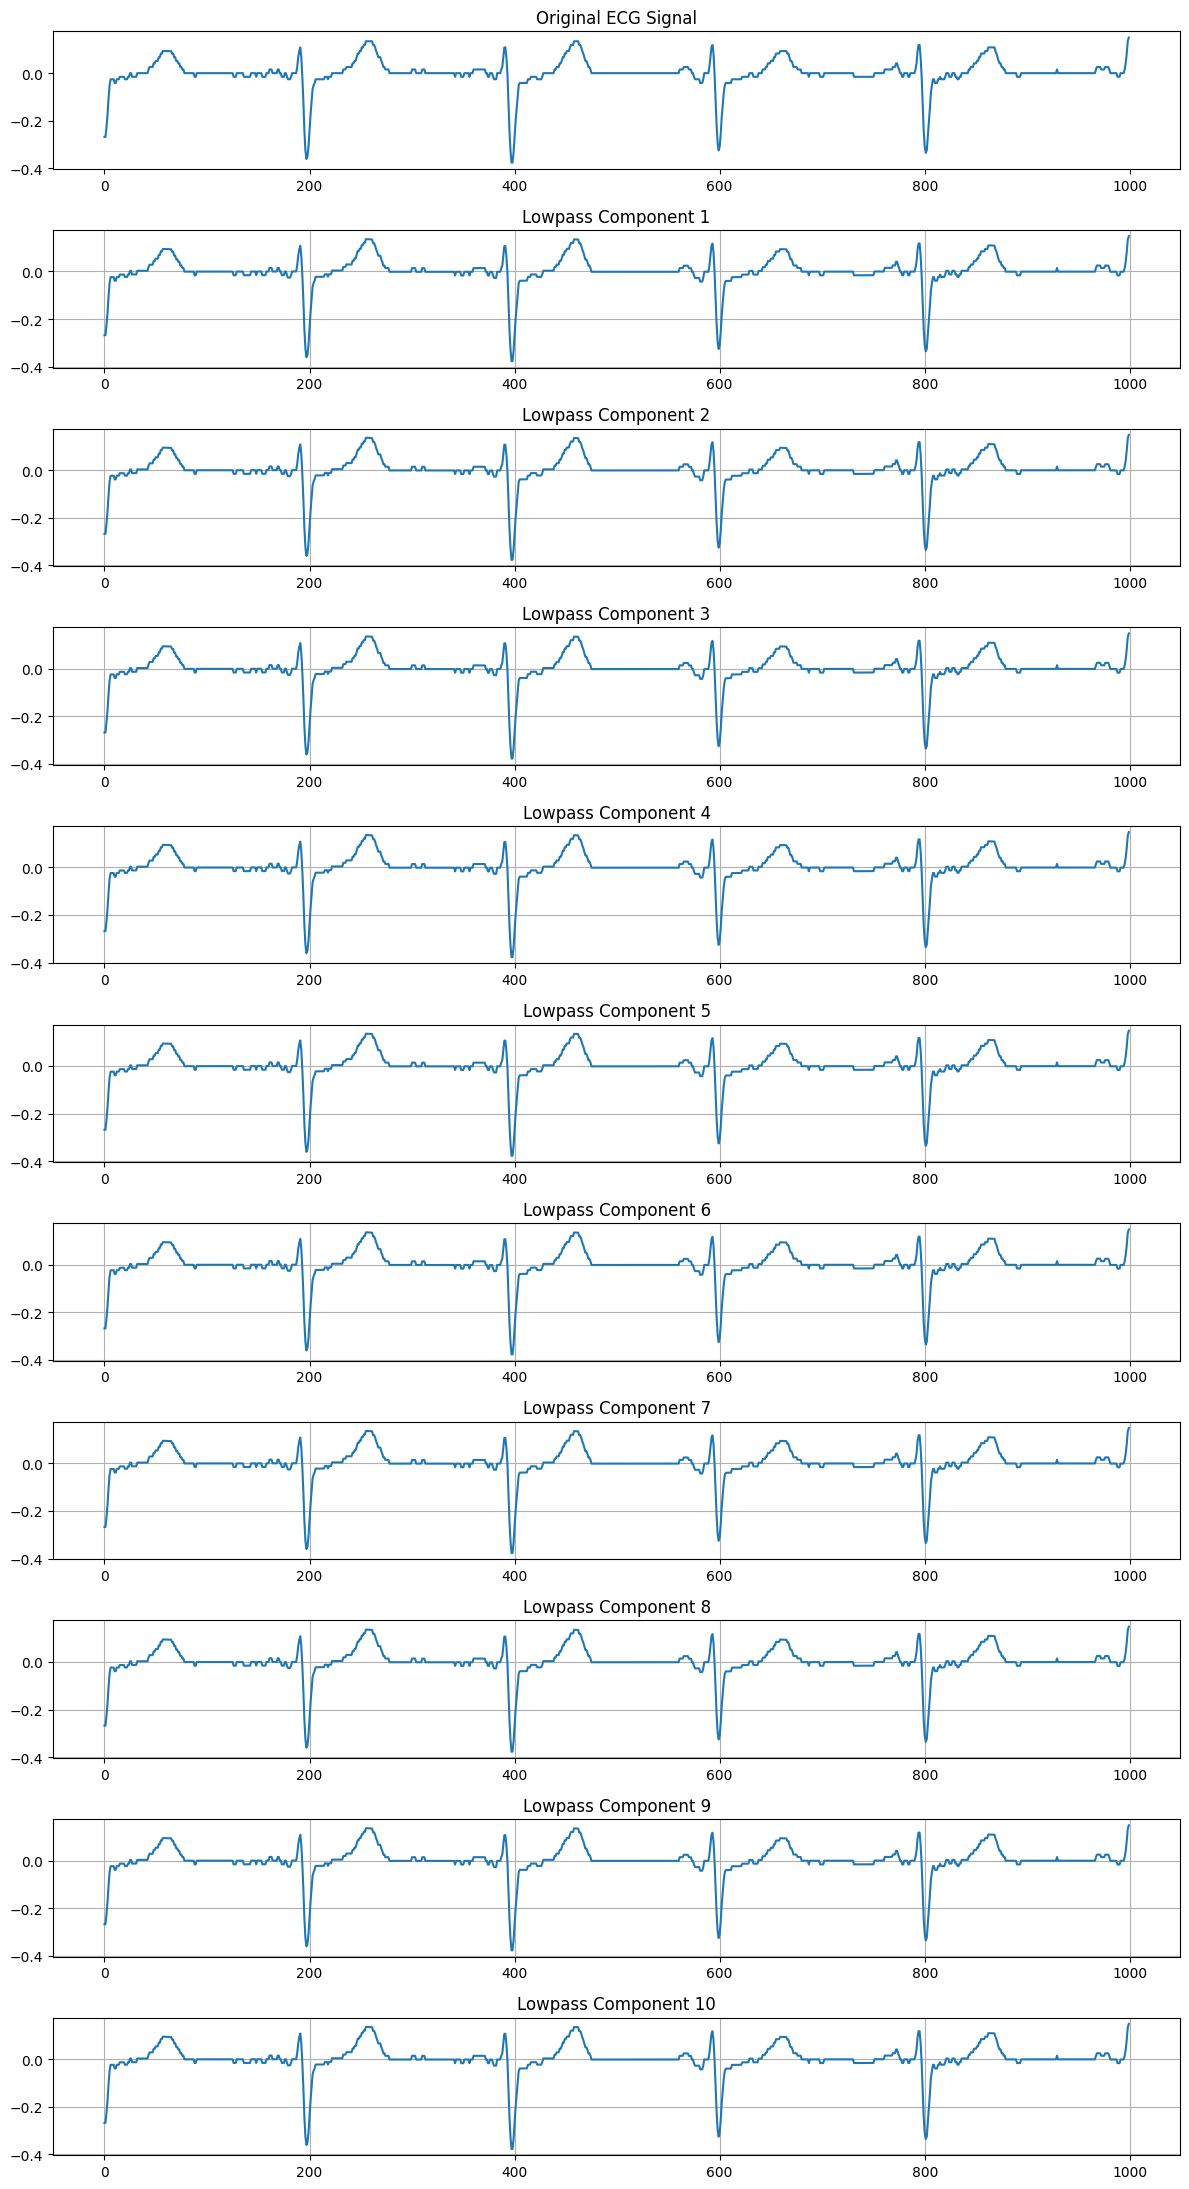

In [188]:

class ECGDecomposer:
    def __init__(self, ecg_signal, num_comp, method='pca', wavelet='db4', window_size=5, lowpass_cutoff=None):
        """
        Initialize the decomposer class.
        
        Parameters:
        - ecg_signal: the ECG time series signal to decompose.
        - num_comp: the number of components to extract from the decomposition.
        - method: the method of decomposition ('pca', 'wavelet', 'emd', 'fft', 'moving_avg', 'lowpass').
        - wavelet: the wavelet type to use for wavelet decomposition (default 'db4').
        - window_size: the window size for moving average decomposition (default 5).
        - lowpass_cutoff: the cutoff frequency for low-pass filtering (default None).
        """
        self.ecg_signal = ecg_signal
        self.num_comp = min(num_comp, len(ecg_signal))
        self.method = method.lower()
        self.wavelet = wavelet
        self.window_size = window_size
        self.lowpass_cutoff = lowpass_cutoff
        
    def decompose(self):
        """
        Decompose the ECG signal based on the selected method.
        
        Returns:
        - A list of decomposed components.
        """
        if self.method == 'pca':
            return self._pca_decomposition()
        elif self.method == 'wavelet':
            return self._wavelet_decomposition()
        elif self.method == 'emd':
            return self._emd_decomposition()
        elif self.method == 'fft':
            return self._fft_decomposition()
        elif self.method == 'moving_avg':
            return self._moving_average_decomposition()
        elif self.method == 'lowpass':
            return self._lowpass_filter_decomposition()
        else:
            raise ValueError(f"Method {self.method} not recognized. Use 'pca', 'wavelet', 'emd', 'fft', 'moving_avg', or 'lowpass'.")

    def _pca_decomposition(self):
        """ Decompose the ECG signal using PCA (Principal Component Analysis). """
        ecg_signal_reshaped = self.ecg_signal.reshape(1, -1)
        pca = PCA(n_components=self.num_comp)
        components = pca.fit_transform(ecg_signal_reshaped)
        return components
    
    def _wavelet_decomposition(self):
        """ Decompose the ECG signal using Wavelet Transform. """
        coeffs = pywt.wavedec(self.ecg_signal, wavelet=self.wavelet, level=self.num_comp-1)
        return coeffs[:self.num_comp]
    
    def _emd_decomposition(self):
        """ Decompose the ECG signal using Empirical Mode Decomposition (EMD). """
        imfs = emd.sift.sift(self.ecg_signal)
        return imfs[:self.num_comp]
    
    def _fft_decomposition(self):
        """ Decompose the ECG signal using Fast Fourier Transform (FFT). """
        fft_coeffs = np.fft.fft(self.ecg_signal)
        # Return the first num_comp coefficients and their inverse FFT representations
        fft_components = [np.fft.ifft(fft_coeffs[:i + 1]).real for i in range(self.num_comp)]
        return fft_components
    
    def _moving_average_decomposition(self):
        """ Compute moving average decomposition. """
        window_sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 150, 170, 200]  # Example window sizes
        comps = []
        comp = self.ecg_signal
        for w in window_sizes[:self.num_comp]:
            comp = np.convolve(comp, np.ones(w) / w, mode='same') #np.convolve(self.ecg_signal, np.ones(w) / w, mode='same')
            comps.append(comp)
        return comps
    
    def _lowpass_filter_decomposition(self):
        """ Apply low-pass filtering to the ECG signal. """
        # Define Butterworth filter parameters
        nyquist = 0.5 * len(self.ecg_signal)  # Nyquist frequency
        cutoff_freqs = np.linspace(0.1, self.lowpass_cutoff, self.num_comp)  # Generate cutoff frequencies
        comps = []
        
        for cutoff in cutoff_freqs:
            # Design Butterworth filter
            b, a = butter(N=4, Wn=cutoff / nyquist, btype='high')
            filtered_signal = lfilter(b, a, self.ecg_signal)
            comps.append(filtered_signal)
        
        return comps
    
def plot_components(original_signal, components, method, wavelet=None):
    """
    Plot the original ECG signal and its decomposed components.
    
    Parameters:
    - original_signal: The original ECG time series signal.
    - components: The decomposed components of the signal.
    - method: The decomposition method used.
    - wavelet: Optional wavelet name if wavelet decomposition is used.
    """
    num_components = len(components)
    fig_height = 2 * (num_components + 1)  # Adjust height based on number of components
    plt.figure(figsize=(12, fig_height))
    
    plt.subplot(num_components + 1, 1, 1)
    plt.plot(original_signal)
    plt.title('Original ECG Signal')
    
    for i, component in enumerate(components):
        plt.subplot(num_components + 1, 1, i + 2)
        plt.plot(component)
        plt.title(f'{method.capitalize()} Component {i + 1}' + (f' ({wavelet})' if wavelet else ''))
        plt.grid()
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Sample ECG signal (for illustration, replace with actual ECG signal)
    original_signal = np.sin(ecg_signal)  # Example synthetic signal
    
    num_comp = 10
    
    # # Decomposition using EMD with 3 components
    # decomposer_emd = ECGDecomposer(ecg_signal, num_comp=num_comp, method='emd')
    # components_emd = decomposer_emd.decompose()
    # plot_components(ecg_signal, components_emd, method='emd')
    
    # # Decomposition using FFT with 3 components
    # decomposer_fft = ECGDecomposer(ecg_signal, num_comp=num_comp, method='fft')
    # components_fft = decomposer_fft.decompose()
    # plot_components(ecg_signal, components_fft, method='fft')
    
    # Decomposition using Moving Average
    # decomposer_moving_avg = ECGDecomposer(original_signal, num_comp=num_comp, method='moving_avg', window_size=[5, 10, 20])
    # components_moving_avg = decomposer_moving_avg.decompose()
    # plot_components(original_signal, components_moving_avg, method='moving_avg')
    
    # Decomposition using Low-pass filtering
    decomposer_lowpass = ECGDecomposer(ecg_signal, num_comp=num_comp, method='lowpass', lowpass_cutoff=0.1)
    components_lowpass = decomposer_lowpass.decompose()
    plot_components(ecg_signal, components_lowpass, method='lowpass')
    
    # # Define a list of wavelets to test
    # wavelets = ['db4', 'haar', 'coif1', 'coif2']
    
    # # Loop through each wavelet and decompose the signal, then plot the components
    # for wavelet in wavelets:
    #     decomposer_wavelet = ECGDecomposer(ecg_signal, num_comp=num_comp, method='wavelet', wavelet=wavelet)
    #     components_wavelet = decomposer_wavelet.decompose()
    #     plot_components(ecg_signal, components_wavelet, method='wavelet', wavelet=wavelet)


In [10]:
print(pywt.wavelist(kind='continuous'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [19]:
import numpy as np
import emd

# Your signal x
x = np.array(signal)  # Replace with your actual signal data

# Perform the decomposition using sift
imfs = emd.sift.sift(x)

# Sum along the second axis (axis=1) to reconstruct the original signal
reconstructed_signal = np.sum(imfs, axis=1)

# Verify the reconstruction
assert np.allclose(x, reconstructed_signal), "Reconstruction failed"

In [14]:
import matplotlib.pyplot as plt

def plot_signals(x, reconstructed_x):
    """
    Plots the original signal and the reconstructed signal on the same graph.
    If one of the signals is None, it only plots the other signal.

    Parameters:
    x (array-like or None): The original signal.
    reconstructed_x (array-like or None): The reconstructed signal.
    """
    plt.figure(figsize=(10, 6))

    # Plot the original signal if it is not None
    if x is not None:
        plt.plot(x, color='blue', label='Original Signal')

    # Plot the reconstructed signal if it is not None
    if reconstructed_x is not None:
        plt.plot(reconstructed_x, color='red', linestyle='--', label='Reconstructed Signal')

    # Add title and labels
    plt.title('Original vs Reconstructed Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Add a legend if at least one signal is plotted
    if x is not None or reconstructed_x is not None:
        plt.legend()

    # Show the plot
    plt.show()


In [ ]:

# Example usage:
plot_signals(x, reconstructed_signal)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_imfs(IMFs, imf_indices=None):
    """
    Plots the specified Intrinsic Mode Functions (IMFs) on the same graph with different colors.

    Parameters:
    IMFs (array-like): The array of IMFs with shape (n_samples, n_imfs).
    imf_indices (list, optional): List of indices of IMFs to plot. If None or empty, all IMFs are plotted.
    """
    plt.figure(figsize=(10, 6))

    num_imfs = IMFs.shape[1]  # Get the number of IMFs
    colors = plt.cm.viridis(np.linspace(0, 1, num_imfs))  # Get distinct colors for each IMF

    # If imf_indices is None or empty, plot all IMFs
    if imf_indices is None or len(imf_indices) == 0:
        imf_indices = range(num_imfs)

    # Iterate through each specified IMF and plot
    for i in imf_indices:
        plt.plot(IMFs[:, i], color=colors[i], label=f'IMF {i+1}')

    # Add title and labels
    plt.title('Intrinsic Mode Functions (IMFs)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [ ]:

# Example usage:
plot_imfs(imfs, imf_indices=[0])
plot_imfs(imfs, imf_indices=[1])
plot_imfs(imfs, imf_indices=[2])
plot_imfs(imfs, imf_indices=[3])
plot_imfs(imfs, imf_indices=[4])
plot_imfs(imfs, imf_indices=[5])
plot_imfs(imfs)  # This will plot all IMFs

In [16]:
def plot_imf_subtractions(x, IMFs):
    """
    Plots the signal after subtracting the sum of the first n IMFs for n ranging from 1 to 5.

    Parameters:
    x (array-like): The original signal.
    IMFs (array-like): The array of IMFs with shape (n_samples, n_imfs).
    """
    len_imfs = IMFs.shape[1]
    for n in range(len_imfs-1, 0, -1):
        x_minus_imf = x - np.sum(IMFs[:, :n], axis=1)
        plot_signals(None, x_minus_imf)
    
    plot_signals(x, x_minus_imf)
    plot_signals(x, np.sum(IMFs, axis=1))


In [ ]:

plot_imf_subtractions(x, imfs)

In [251]:
from box import Box
import numpy as np
import pywt
from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt
import emd

class SignalDecomposer:
    def __init__(self, original_signal, num_comp, method='emd'):
        """
        Initialize the decomposer class.
        
        Parameters:
        - original_signal: the signal to decompose.
        - num_comp: the number of components to extract from the decomposition.
        - method: the method of decomposition ('pca', 'wavelet', 'emd', 'fft', 'moving_avg', 'lowpass').
        """
        self.attributes = Box(default_box=True, default_box_none_transform=True)
        self.attributes.original_signal = original_signal
        self.attributes.num_comp = num_comp
        self.attributes.method = method.lower()
        self.attributes.fs = 250  # Default sampling frequency
        
    def decompose(self, method=None, extra_params: dict = {}):
        """
        Decompose the signal based on the selected method.
        
        Returns:
        - A list of decomposed components.
        """
        if method is not None:
            self.attributes.method = method.lower()
            
        self.attributes.update(extra_params)    
            
        print(f"Decomposing signal using {self.attributes.method} method to extract {self.attributes.num_comp} components")
        if self.attributes.method == 'pca':
            return self._pca_decomposition()
        elif self.attributes.method == 'wavelet':
            return self._wavelet_decomposition()
        elif self.attributes.method == 'emd':
            return self._emd_decomposition()
        elif self.attributes.method == 'hht':
            return self._hht_decomposition()
        elif self.attributes.method == 'fft':
            return self._fft_decomposition()
        elif self.attributes.method == 'moving_avg':
            return self._moving_average_decomposition()
        elif self.attributes.method == 'lowpass':
            return self._lowpass_filter_decomposition()
        else:
            raise ValueError(f"Method {self.attributes.method} not recognized. Use 'pca', 'wavelet', 'emd', 'fft', 'moving_avg', or 'lowpass'.")

    def reconstruct(self, components, method=None, extra_params: dict = {}):
        """
        Reconstruct the signal from the decomposed components.
        
        Parameters:
        - components: the list of decomposed components.
        
        Returns:
        - The reconstructed signal.
        """
        if method is not None:
            self.attributes.method = method.lower()
            
        self.attributes.update(extra_params)
        
        print(f"reconstruction signal using {self.attributes.method} method from {self.attributes.num_comp} components")
        if self.attributes.method == 'pca':
            return self._pca_reconstruct(components)
        elif self.attributes.method == 'wavelet':
            return self._wavelet_reconstruct(components)
        elif self.attributes.method == 'emd':
            return self._emd_reconstruct(components)
        elif self.attributes.method == 'hht':
            return self._hht_reconstruct(components)
        elif self.attributes.method == 'fft':
            return self._fft_reconstruct(components)
        elif self.attributes.method == 'moving_avg':
            return self._moving_average_reconstruct(components)
        elif self.attributes.method == 'lowpass':
            return self._lowpass_filter_reconstruct(components)
        else:
            raise ValueError(f"Method {self.attributes.method} not recognized. Use 'pca', 'wavelet', 'emd', 'fft', 'moving_avg', or 'lowpass'.")
        
    def _pca_decomposition(self):
        """ Decompose the signal using PCA (Principal Component Analysis). """
        raise NotImplementedError("Has bugs. PCA decomposition is not yet implemented.")
        
        signal_reshaped = self.attributes.original_signal.reshape(-1, 1)  # Reshape to 2D for PCA

        # Perform PCA decomposition
        pca = PCA(n_components=self.attributes.num_comp)
        components = pca.fit_transform(signal_reshaped)

        # Reconstruct the signal using the specified number of components
        reconstructed_signal = pca.inverse_transform(components)
        
        assert np.allclose(self.attributes.original_signal, reconstructed_signal), "Reconstruction failed"
        
        return components
    
    def _pca_reconstruct(self, components):
        raise NotImplementedError("Has bugs. PCA decomposition is not yet implemented.")
    
    def _wavelet_decomposition(self):
        """ Decompose the signal using Wavelet Transform. """
        coeffs = pywt.wavedec(self.attributes.original_signal, wavelet=self.attributes.wavelet, level=self.attributes.num_comp-1)
        
        reconstructed_signal = self._wavelet_reconstruct(coeffs)
        assert np.allclose(self.attributes.original_signal, reconstructed_signal, atol=1.e-10), "Reconstruction failed"
        return coeffs
    
    def _wavelet_reconstruct(self, components):
        reconstructed_signal = pywt.waverec(components, wavelet=self.attributes.wavelet)
        return reconstructed_signal
    
    def _emd_decomposition(self):
        """ Decompose the signal using Empirical Mode Decomposition (EMD). """
        imfs = emd.sift.sift(self.attributes.original_signal, max_imfs=self.attributes.num_comp-1)
        imfs = imfs.T
        assert imfs.shape[0] == self.attributes.num_comp, f"Insufficient IMFs for reconstruction: {imfs.shape[0]}, {self.attributes.num_comp}"
        # Sum the first num_comp IMFs along axis 1 to reconstruct the signal
        reconstructed_signal = self._emd_reconstruct(imfs)
        assert np.allclose(self.attributes.original_signal, reconstructed_signal), "Reconstruction failed"
        
        return imfs
    
    def _emd_reconstruct(self, components):
        """ Reconstruct the signal using Empirical Mode Decomposition (EMD). """
        reconstructed_signal = np.sum(components, axis=0)
        return reconstructed_signal
    
    def _hht_decomposition(self):
        """ Decompose the signal using Hilbert-Huang Transform (HHT). """
        # Step 1: Decompose the signal using EMD (Empirical Mode Decomposition)
        imfs = emd.sift.sift(self.attributes.original_signal, max_imfs=self.attributes.num_comp-1)
        imfs = imfs.T
        
        # Step 2: Perform Hilbert Transform on the imfs to obtain instantaneous frequency and amplitude
        analytic_signal = hilbert(imfs)
        amplitude_envelope = np.abs(analytic_signal).T
        instantaneous_phase = np.unwrap(np.angle(analytic_signal)).T
        instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0 * np.pi)).T
        
        def hht_plt():
            # Plotting
            fig, axs = plt.subplots(3, 1, figsize=(12, 8))
            
            print(f"{imfs.shape=}"\
                    f"{amplitude_envelope.shape=}\n" \
                    f"{instantaneous_phase.shape=}\n" \
                    f"{instantaneous_frequency.shape=}\n"
                )

            # Plot amplitude envelope
            axs[0].plot(amplitude_envelope)
            axs[0].set_title('Amplitude Envelope')
            axs[0].set_xlabel('Sample')
            axs[0].set_ylabel('Amplitude')

            # Plot instantaneous phase
            axs[1].plot(instantaneous_phase)
            axs[1].set_title('Instantaneous Phase')
            axs[1].set_xlabel('Sample')
            axs[1].set_ylabel('Phase (radians)')

            # Plot instantaneous frequency
            axs[2].plot(instantaneous_frequency)
            axs[2].set_title('Instantaneous Frequency')
            axs[2].set_xlabel('Sample')
            axs[2].set_ylabel('Frequency (Hz)')
            
            plot_signals(self.attributes.original_signal, None)
            
        # hht_plt()

        # Reconstruct the signal
        reconstructed_signal = self._hht_reconstruct(imfs)

        # Check if the reconstruction is correct
        assert np.allclose(reconstructed_signal, self.attributes.original_signal), "Reconstruction failed"

        return imfs
    
    def _hht_reconstruct(self, components):
        """ Reconstruct the signal using Hilbert-Huang Transform (HHT). """
        reconstructed_signal = np.sum(components, axis=0)
        return reconstructed_signal       
    
    def _fft_decomposition(self):
        """ Decompose the signal using Fast Fourier Transform (FFT). """
        # Perform FFT on the original signal
        fft_coeffs = np.fft.fft(self.attributes.original_signal)
        
        fft_coeffs = fft_coeffs[:250]
        
        print(f"{len(fft_coeffs)} FFT coefficients")
        
        # Get the number of coefficients
        num_coeffs = len(fft_coeffs)

        # Create a list to hold the selected components
        fft_components = []
        
        step = num_coeffs // self.attributes.num_comp
        
        # Divide the coefficients into self.attributes.num_comp parts
        for i in range(0, num_coeffs, step):
            # Zero out all coefficients except the current part
            temp_coeffs = np.zeros_like(fft_coeffs, dtype=complex)
            temp_coeffs[:i+step] = fft_coeffs[:i+step]
            
            # Compute the inverse FFT to get the time domain representation of the selected components
            partial_comp = np.fft.ifft(temp_coeffs).real
            fft_components.append(partial_comp)
        
        # for i in range(self.attributes.num_comp, step=step):
        #     # Create a copy of the FFT coefficients and set the rest to zero for reconstruction
        #     modified_coeffs = np.zeros(num_coeffs, dtype=complex)
        #     modified_coeffs[:i + 1] = fft_coeffs[:i + 1]  # Retain the first (i + 1) coefficients

        #     # Compute the inverse FFT to get the time domain representation of the selected components
        #     fft_components.append(np.fft.ifft(modified_coeffs).real)

        # Reconstruct the original signal using the selected components
        
        
                  
        return fft_components
    
    def _fft_reconstruct(self, components):
        """ Reconstruct the signal using Fast Fourier Transform (FFT). """
        raise NotImplementedError("FFT reconstruction is hard to implement.")
        
    def _moving_average_decomposition(self):
        """ Compute moving average decomposition. """
        window_sizes = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 150, 170, 200]  # Example window sizes
        comps = []
        comp = self.attributes.original_signal
        for w in window_sizes[:self.attributes.num_comp]:
            comp = np.convolve(comp, np.ones(w) / w, mode='same')
            comps.append(comp)
        return comps
    
    def _moving_average_reconstruct(self, components):
        """ Reconstruct the signal using moving average decomposition. """
        raise NotImplementedError("Moving average reconstruction is hard to implement.")
    
    def _lowpass_filter_decomposition(self):
        """ Apply low-pass filtering to the signal. """
        # Define Butterworth filter parameters
        nyquist = 0.5 * 250  # Nyquist frequency
        cutoff_freqs = np.linspace(0.1 * nyquist, self.attributes.lowpass_cutoff, self.attributes.num_comp)  # Generate cutoff frequencies
        comps = []
        
        for cutoff in cutoff_freqs:
            # Design Butterworth filter
            b, a = butter(N=self.attributes.num_comp, Wn=cutoff / nyquist, btype='low')
            filtered_signal = lfilter(b, a, self.attributes.original_signal)
            comps.append(filtered_signal)
        
        return np.array(comps)
    
        nyquist = 0.5 * len(self.attributes.original_signal) # Nyquist frequency
        cutoff_freqs = np.linspace(0.1, self.attributes.lowpass_cutoff, self.attributes.num_comp)  # Generate cutoff frequencies
        comps = []
        
        for cutoff in cutoff_freqs:
            # Design Butterworth filter
            b, a = butter(N=self.attributes.num_comp, Wn=cutoff / nyquist, btype='high')
            filtered_signal = filtfilt(b, a, self.attributes.original_signal)
            comps.append(filtered_signal)
            
        reconstructed_signal = self._lowpass_filter_reconstruct(comps)
        
        return np.array(comps).T
    
    def _lowpass_filter_reconstruct(self, components):
        """ Reconstruct the signal using low-pass filtering. """
        raise NotImplementedError("Low-pass filter not suitable for reconstraction.")
    



# Example usage
num_comp = 5   
signal_decomposer = SignalDecomposer(x, num_comp=num_comp)

#emd
emd_components = signal_decomposer.decompose(method='emd')

#wavelet
wavelets = ['db4', 'haar', 'coif1', 'coif2']
for wavelet in wavelets:
    components_wavelet = signal_decomposer.decompose(method='wavelet', extra_params={'wavelet': wavelet})
    # plot_components(ecg_signal, components_wavelet, method='wavelet', wavelet=wavelet)
    
#fft
decomposer_fft = signal_decomposer.decompose(method='fft', extra_params={'num_comp': num_comp})

# lowpass
decomposer_lowpass = signal_decomposer.decompose(method='lowpass', extra_params={'lowpass_cutoff': 0.1})

#hht
decomposer_hht = signal_decomposer.decompose(method='hht')

Decomposing signal using emd method to extract 5 components
Decomposing signal using wavelet method to extract 5 components
Decomposing signal using wavelet method to extract 5 components
Decomposing signal using wavelet method to extract 5 components
Decomposing signal using wavelet method to extract 5 components
Decomposing signal using fft method to extract 5 components
250 FFT coefficients
Decomposing signal using lowpass method to extract 5 components
Decomposing signal using hht method to extract 5 components


In [147]:
# plot_components(ecg_signal, decomposer_fft, method='fft')
for i, comp in enumerate(decomposer_lowpass):
    print(f"components_wavelet {i + 1}: {type(comp)}, shape: {len(comp)}")

components_wavelet 1: <class 'numpy.ndarray'>, shape: 1000
components_wavelet 2: <class 'numpy.ndarray'>, shape: 1000
components_wavelet 3: <class 'numpy.ndarray'>, shape: 1000
components_wavelet 4: <class 'numpy.ndarray'>, shape: 1000
components_wavelet 5: <class 'numpy.ndarray'>, shape: 1000


In [207]:
decomposer_lowpass.shape

(5, 1000)

In [241]:
import numpy as np
from sklearn.decomposition import PCA
import emd

def decompose_and_reconstruct(x, num_comp, method='emd'):
    """
    Decomposes the signal using the specified method and reconstructs it using the first num_comp components.

    Parameters:
    x (array-like): The original signal.
    num_comp (int): The number of components to use for reconstruction.
    method (str): The decomposition method to use ('emd' by default, 'pca' for PCA).

    Returns:
    tuple: A tuple containing the components (IMFs or principal components) and the reconstructed signal.
    """
    if method == 'emd':
        # Perform the decomposition using sift
        IMFs = emd.sift.sift(x)
        
        # Check the shape of the IMFs
        print("EMD IMFs shape:", IMFs.shape)  # (signal_length, num_imfs)
        num_comp = min(num_comp, IMFs.shape[1])  # Ensure num_comp does not exceed available IMFs

        # Sum the first num_comp IMFs along axis 1 to reconstruct the signal
        reconstructed_x = np.sum(IMFs[:, :num_comp], axis=1)
        
    elif method == 'pca':
        raise NotImplementedError("Has bugs. PCA decomposition is not yet implemented.")
        # Reshape x for PCA if necessary
        x_reshaped = x.reshape(-1, 1)  # Reshape to 2D for PCA
        print("PCA input shape:", x_reshaped.shape)

        # Perform PCA decomposition
        pca = PCA(n_components=num_comp)
        components = pca.fit_transform(x_reshaped)

        # Reconstruct the signal using the specified number of components
        reconstructed_x = pca.inverse_transform(components)

    else:
        raise ValueError(f"Unsupported method: {method}")

    # Verify the reconstruction
    assert x.shape == reconstructed_x.shape, "Reconstruction failed"

    return components, reconstructed_x.flatten()  # Return flattened reconstructed signal

# Example usage:
# x = np.array([...])  # Your signal here
num_comp = 5
components, reconstructed_x = decompose_and_reconstruct(x, num_comp=num_comp, method='pca')

NotImplementedError: Has bugs. PCA decomposition is not yet implemented.

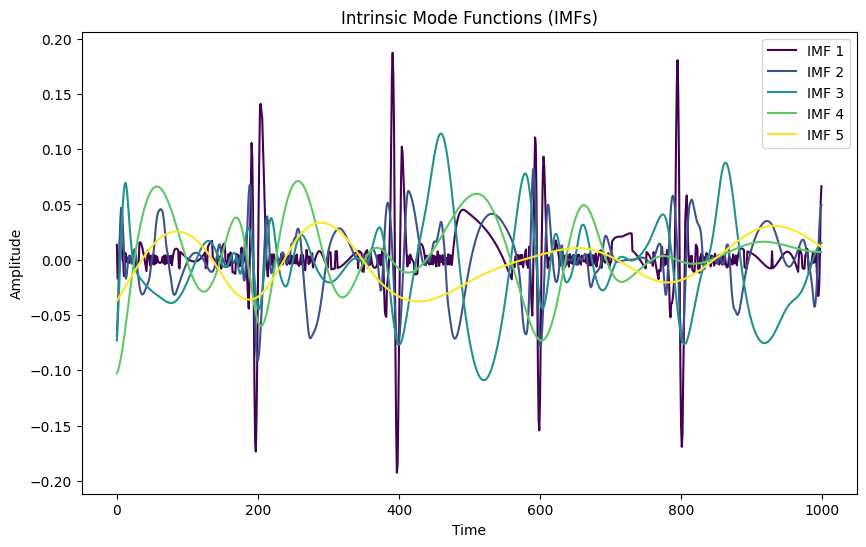

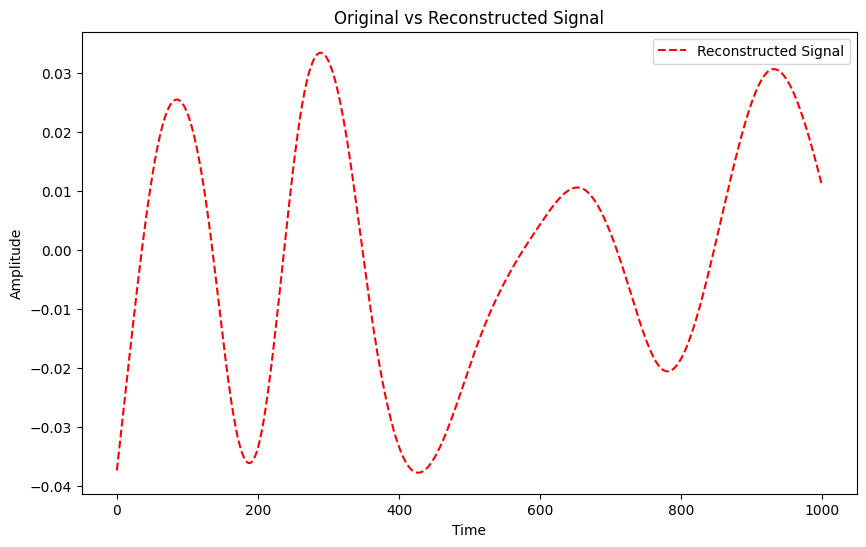

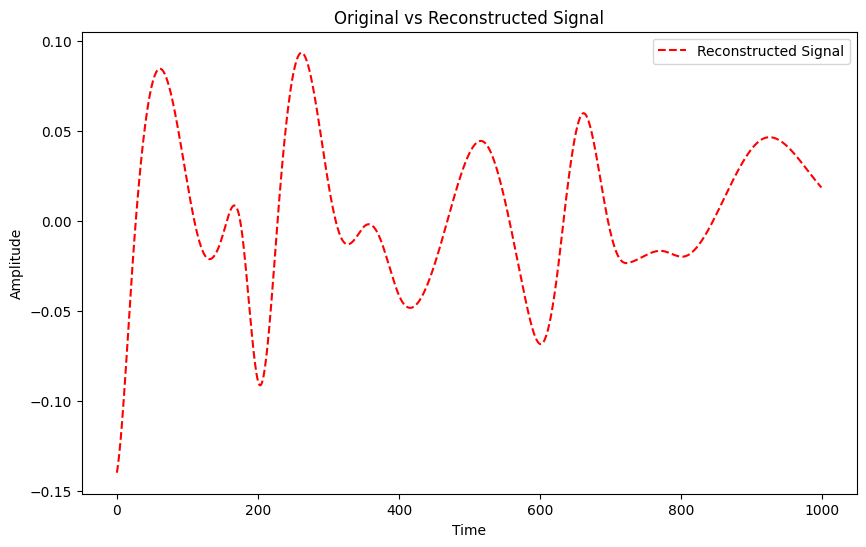

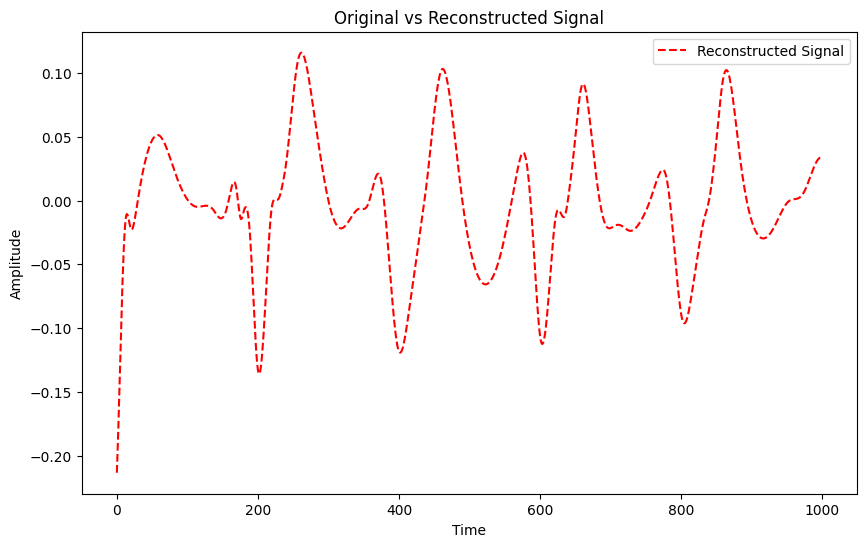

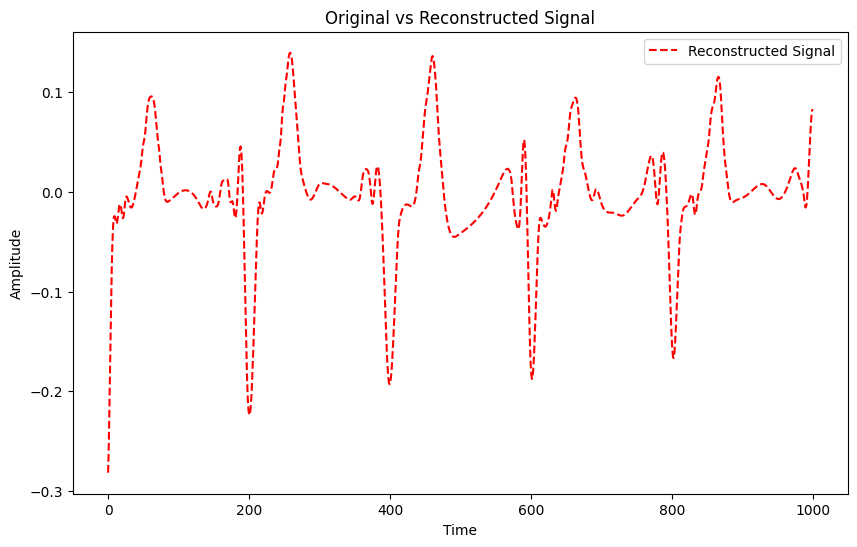

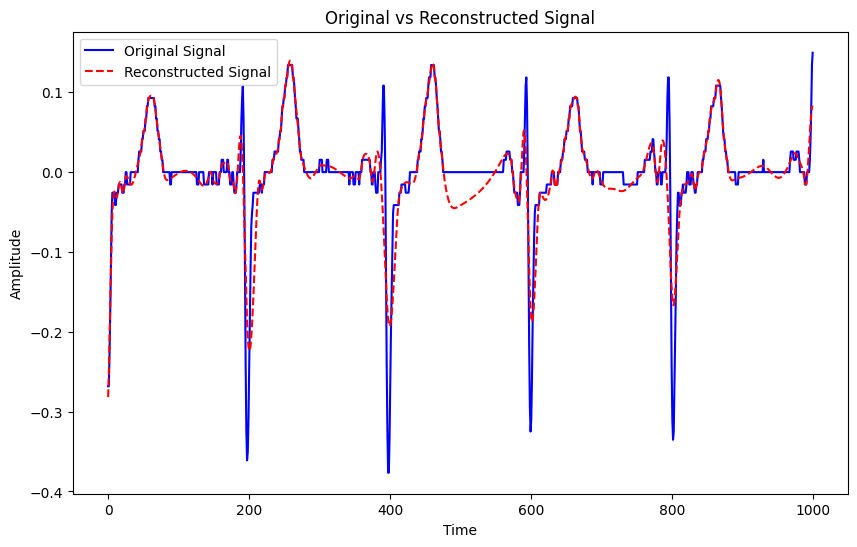

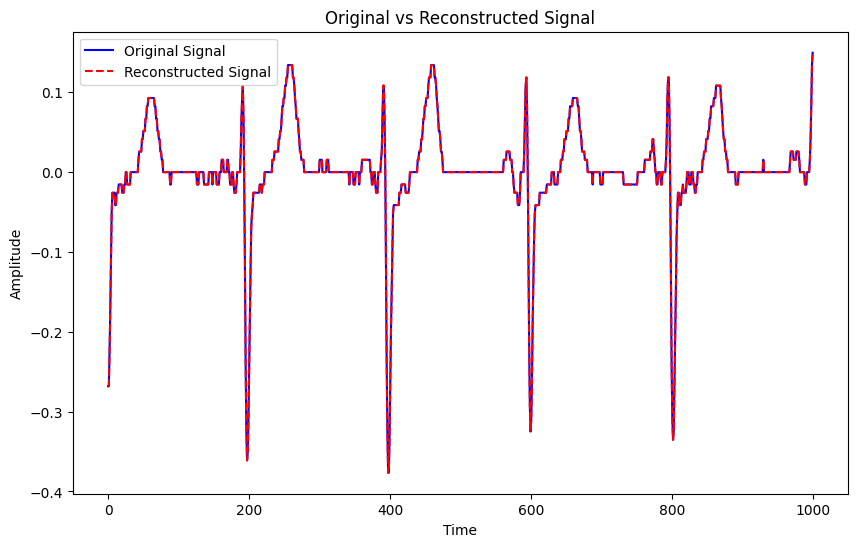

In [227]:
plot_imfs(imfs)
plot_imf_subtractions(x, imfs)